In [1]:
!nvidia-smi

Wed Jun 25 13:25:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.40                 Driver Version: 576.40         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   57C    P8             14W /  130W |     136MiB /   6144MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Practico 1 U3

In [2]:
import torch #Redes neuronales
import pandas as pd #Dataframes

In [3]:
from torchvision.models import resnet50 #Importar una red neuronal
                                        #existente

In [4]:
from PIL import Image #Librería para trabajar con imágenes

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.current_device()

0

In [7]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [8]:
device = torch.device("cuda") #Move to gpu

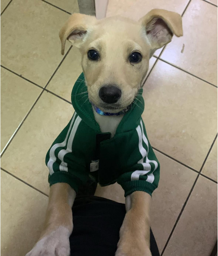

In [9]:
img = Image.open("../datasets/snoopy.jpeg") #Open image
img.thumbnail(size=(256,256)) #Make thumnbial
img #Display

In [10]:
model = resnet50(weights="IMAGENET1K_V1") #Instanciamos el objeto
model.to(device) #Move to gpu

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
imagenet_labels = pd.read_csv("../datasets/imagenet_labels.csv", sep = ": ")
imagenet_labels

C:\Users\Gabriel\AppData\Local\Temp\ipykernel_10856\1603415821.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  imagenet_labels = pd.read_csv("../datasets/imagenet_labels.csv", sep = ": ")


,id,label
0,0,"tench, Tinca tinca"
1,1,"goldfish, Carassius auratus"
2,2,"great white shark, white shark, man-eater, man..."
3,3,"tiger shark, Galeocerdo cuvieri"
4,4,"hammerhead, hammerhead shark"
...,...,...
995,995,earthstar
996,996,"hen-of-the-woods, hen of the woods, Polyporus ..."
997,997,bolete
998,998,"ear, spike, capitulum"


## Use model

In [12]:
from torchvision import transforms #Transformaciones a la imagen

In [13]:
preprocessing = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225])
])
#Transformamos la imagen
#Resize a 256x256
#Recortamos al centro a 224x224,
#Convertimos a tensor
#Normalizamos
#preprocessing

In [14]:
img_transformed = preprocessing(img).to(device)
#Transformamos la imagen
#Moverla a la GPU
img_transformed.shape

torch.Size([3, 224, 224])

In [15]:
batch = torch.unsqueeze(img_transformed, 0)
#Agregar una dimension al principio para generar un batch
batch.shape

torch.Size([1, 3, 224, 224])

In [16]:
model.eval() #Modelo en modo evaluación
y_prob = model(batch) #Evaluamos el modelo con la imagen del snoopy
y_prob.shape #Me genera la siguiente predicción

torch.Size([1, 1000])

In [17]:
index = y_prob.argmax().item()
#Cual es el valor mas grande
imagenet_labels.iloc[index]
#Lo buscamos en el dataframe de las etiquetas

id           172
label    whippet
Name: 172, dtype: object

Aquí lo único que hicimos fue usar un modelo

# Transfer learning

In [18]:
from torchvision.datasets import ImageFolder #Localizar una carpeta y sus imagenes
from torch.utils.data import DataLoader #Genera un "generador"
from torch.nn import CrossEntropyLoss #Loss function
from torch.optim import SGD #Stochastic gradient descent

In [19]:
train_folder = ImageFolder("../datasets/cats_dogs/train", transform=preprocessing) #Train
val_folder = ImageFolder("../datasets/cats_dogs/val", transform=preprocessing) #Val

In [20]:
#Generadores
train_loader = DataLoader(train_folder, batch_size=32)
val_loader = DataLoader(val_folder, batch_size=32)
#Generadores de imagenes con batch size = 32
# (tamaño de cada lote)

In [21]:
for params in model.parameters():
    params.requires_grad = False
    #Congelar los gradientes de mi red

In [22]:
model.fc = torch.nn.Linear(model.fc.in_features, 2)
#Reemplazar la capa final de la red por una nueva
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
loss_fn = CrossEntropyLoss()
optimizer = SGD(params=model.fc.parameters(), lr=1e-4) #0.0001

In [24]:
#Training loop
model.to(device) #Mover el modelo a la GPU
train_losses = []
val_losses = []
epochs = 10 #Seteamos un número de épocas
for epoch in range(epochs):
    model.train() #Modo entrenamiento
    train_loss = 0
    for inputs, labels in train_loader:
        #Montar los datos en la GPU
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad() #Limpiar los gradientes
        y_prob = model(inputs) #Forward pass
        loss = loss_fn(y_prob, labels) #Calcular la loss
        loss.backward() #Backward pass
        optimizer.step() #Actualizar los pesos
        train_loss += loss.item() #Sumatoria
    #Promediamos
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss) #Guardar la loss de training
    model.eval() #Modo evaluación
    val_loss = 0
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device) #Montar los datos en la GPU
        y_prob = model(inputs) #Forward pass
        loss = loss_fn(y_prob, labels) #Calcular la loss
        val_loss += loss.item()
    #Promediamos
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss) #Guardar la loss de validacion
    print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")


Epoch 0, Train Loss: 0.7522710892889235, Val Loss: 0.7456048925717672
Epoch 1, Train Loss: 0.7160260611110263, Val Loss: 0.7012424071629842
Epoch 2, Train Loss: 0.6922634641329447, Val Loss: 0.6718378861745199
Epoch 3, Train Loss: 0.6767909195688036, Val Loss: 0.6519377529621124
Epoch 4, Train Loss: 0.6667589479022555, Val Loss: 0.6377649207909902
Epoch 5, Train Loss: 0.66027922100491, Val Loss: 0.6273207664489746
Epoch 6, Train Loss: 0.6561148001088036, Val Loss: 0.619576225678126
Epoch 7, Train Loss: 0.6534581018818749, Val Loss: 0.6137274106343588
Epoch 8, Train Loss: 0.6517822411325243, Val Loss: 0.6092106203238169
Epoch 9, Train Loss: 0.6507427824868096, Val Loss: 0.6057002743085226


<Axes: >

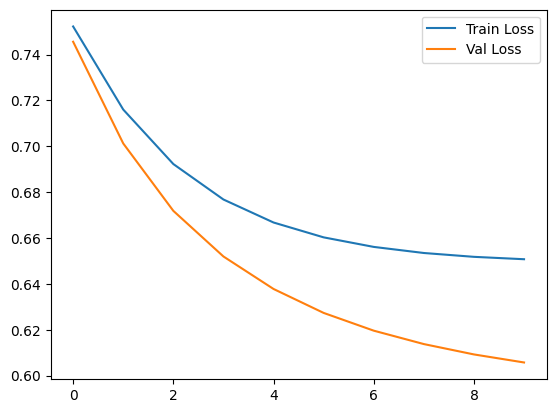

In [25]:
import seaborn as sns
sns.lineplot(x = range(epochs), y= train_losses, label = "Train Loss")
sns.lineplot(x = range(epochs), y= val_losses, label = "Val Loss")

In [28]:
batch.shape #Foto del snoopy
model.eval() #Modo evaluación
y_prob = model(batch) #Evaluamos el modelo con la imagen del snoopy
y_prob

tensor([[-0.5527,  0.3976]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [29]:
from torch.nn import Softmax
softmax = Softmax(dim=1) #Softmax para convertir a probabilidades
y_prob = softmax(y_prob)
y_prob = y_prob.cpu().detach().numpy() #Convertir a numpy
pd.DataFrame(y_prob, columns=["Cat", "Dog"], index=["Snoopy"])

,Cat,Dog
Snoopy,0.278826,0.721174
